# A Hierarchical Model of Honeybee Waggle-Dances
Details
     AUTHOR:	James Foster              DATE: 2025 03 14
   MODIFIED:	James Foster              DATE: 2024 09 23

DESCRIPTION: Fit a hierarchical maximum-likelihood von Mises to honeybee waggle-run angles.
            
     INPUTS: 
            
    OUTPUTS: Plots and test statistics

    CHANGES: - More comprehensive simulation

REFERENCES: Sayin S, ... Graving JM, et al. (2025)
            The behavioral mechanisms governing collective motion in swarming locusts.
            Science 387,995-1000
            DOI:10.1126/science.adq7832

            Graving JM & Foster JJ in preparation
            Unwrapping Circular Statistics: Bayesian Linear Models for Circular Data

In [1]:
#set up required packages
##JJF make sure to select a conda environment as the kernel!
##JJF to use g++, before running: conda install m2w64-toolchain

import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap 

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to c:\users\james foster\appdata\local\temp\pip-req-build-l24se3y_
  Resolved https://github.com/jgraving/unwrap to commit b158ec9cf3b6d06ed4c9baa721978c7a1ab1dd84
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11617 sha256=c5120a741f0a96bca08362b498ad47b299abbc3242e07dc97c00bd3d85b9aa3d
  Stored in directory: C:\Users\James Foster\AppData\Local\Temp\pip-ephem-wheel-cache-2_s6bnzx\wheels\6d\a6\84\e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap 'C:\Users\James Foster\AppData\Local\Temp\pip-req-build-l24se3y_'


## Import and format the data
Load the preprocessed data from CSV and convert to radians. Relabel the two conditions in each factor to binary.

In [2]:

import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'colour_dance_reorg.csv'#JJF windows is having trouble finding this file
df = pd.read_csv(file_path, sep=',')

# Create a binary indicator for the light intensity (1 for 'low', 0 for 'high')
df['B'] = df['brightn'].apply(lambda x: 1 if 'l' in x else 0)
# Create a binary indicator for the light colour (1 for 'UV', 0 for 'green')
df['C'] = df['colour'].apply(lambda x: 1 if 'u' in x else 0)

# Convert the dance angle column to the correct format (already radians?)
df['angle'] = pd.to_numeric(df['angle'], errors='coerce')  # Convert non-numeric values (e.g., 'NA') to NaN

# Normalise all angles to be between -pi and pi (should be already)
df['angle'] = df['angle'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)
df['sun_az_rad'] = df['sun_az_rad'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# Keep only the relevant columns and drop rows with missing values
df = df[['ID', 'B', 'C', 'run', 'angle', 'sun_az_rad']].dropna().copy()
df.reset_index(drop=True, inplace=True)

# Rename columns: change 'Beetle' to 'Individual'
df = df.rename(columns={'ID': 'Individual'})
df['Individual'] = df['Individual'].astype('category')

df.head()

,Individual,B,C,run,angle,sun_az_rad
0,2016.05.31.14.24,1,1,1,-1.570796,-2.647205
1,2016.05.31.14.24,1,1,2,0.087266,-2.647205
2,2016.05.31.14.24,1,1,3,0.349066,-2.647205
3,2016.05.31.14.24,1,1,4,-0.698132,-2.647205
4,2016.05.31.14.24,1,1,5,0.349066,-2.647205


## Inspect the data
Use Jake's plots to show the repeated angles across individuals.
Maybe limit this to just 10 individuals for now.

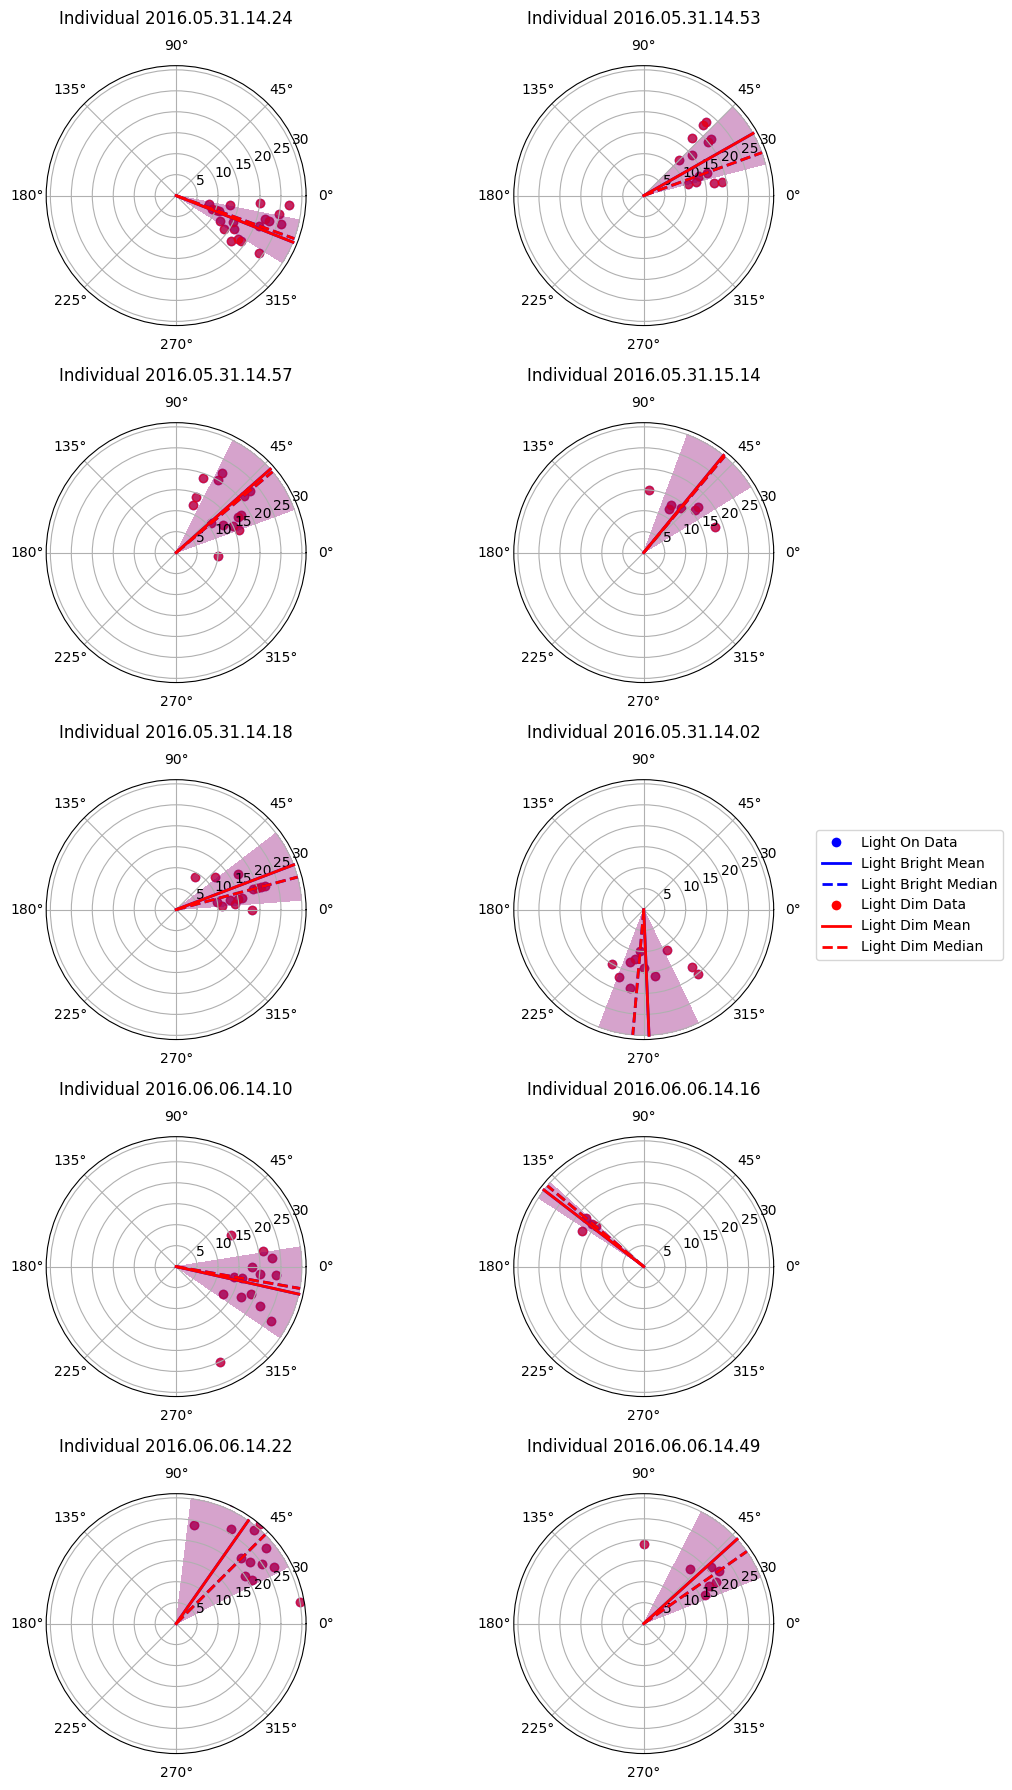

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Helper function to compute and plot summary statistics.
# It plots a solid vertical line at the circular mean and a dashed vertical line at the circular median,
# both in the specified color. It also fills the region ± the circular standard deviation.
def plot_summary_stats(ax, angles, radial_max, color):
    # Compute circular mean, median, and standard deviation.
    mean_val = circmean(angles, high=np.pi, low=-np.pi)
    median_val = circ_median(angles)
    std_val = circstd(angles, high=np.pi, low=-np.pi, normalize=True)
    
    # Plot mean (solid) and median (dashed).
    ax.plot([mean_val, mean_val], [0, radial_max], color=color, linewidth=2)
    ax.plot([median_val, median_val], [0, radial_max], color=color, linewidth=2, linestyle='--')
    
    # Fill the region between mean minus std and mean plus std.
    theta_vals = np.linspace(mean_val - std_val, mean_val + std_val, 100)
    r_vals = np.linspace(0, radial_max, 100)
    Theta, R = np.meshgrid(theta_vals, r_vals)
    ax.contourf(Theta, R, np.ones_like(Theta), alpha=0.2, colors=[color])
    
    return mean_val, median_val, std_val

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()
unique_individuals = unique_individuals[range(0,10)] # for now just the 1st 10

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = 5, 2  # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 10*3  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    individual_data = df[df['Individual'] == individual]
    
    # Separate Light bright and Light dim data (drop NaNs in angle).
    data_on = individual_data[individual_data['B'] == 0].dropna(subset=['angle'])
    data_off = individual_data[individual_data['B'] == 0].dropna(subset=['angle'])
    
    # Scatter-plot data.
    plot_scatter(ax, data_on, 'angle', 'run', 'blue', 'Light Bright')
    plot_scatter(ax, data_off, 'angle', 'run', 'red', 'Light Dim')
    
    # Plot summary statistics for each condition.
    if not data_on.empty:
        plot_summary_stats(ax, data_on['angle'].values, radial_max, 'blue')
    if not data_off.empty:
        plot_summary_stats(ax, data_off['angle'].values, radial_max, 'red')
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)

# Create a shared custom legend.
legend_handles = [
    # For Light On (blue)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Light Bright Data'),
    Line2D([0], [0], color='blue', lw=2, label='Light Bright Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Light Bright Median'),
    # For Light Off (red)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Light Dim Data'),
    Line2D([0], [0], color='red', lw=2, label='Light Dim Mean'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Light Dim Median'),
]

# Add one shared legend to the right of the figure.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.10, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()

## Fit a circular model with individual effects but no interactions
To begin with fit a model with only the effects of different individuals, light intensities and LED colours.

In [ ]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "angle ~ B + C + (1 + B + C |Individual)",
    "kappa ~ B + C + (1 + B + C |Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "B": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    "C": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "B|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    "C|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "B|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "C|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model = bmb.Model(
    formula,
    df,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model)

# Fit the model.
idata = model.fit(draws=1000) # be prepared for this to take a very long time to run on Windows!